# Jリーグの観客動員数予測 (SIGNATE 練習問題用コンペティション)

#### 【課題】
観客数や集客率は、プロスポーツビジネスにおいて収益を考える上で重要な数字です。<br>
例えばJリーグクラブの収益割合は、入場料収入が広告料収入に次いで2割を占めています。入場料収入は観客数に比例するので、クラブは観客数を一人でも増やしたいと考えています。<br>
観客数をあらかじめ予測することができれば、観客数が少ないと予測された試合は、チケット価格を下げて観客数を増やしたりといった施策を打つことができます。<br>
この課題への取り組みの1つとして、Jリーグの試合の観客数を予測するモデル作成に挑戦します。<br>

#### 【本コンペについて】
このコンペティションは『2012年～2014年シーズン前半までのデータを使って、2014年後半戦J1,J2全試合の観客動員数を予測するモデルを作成する』という内容の練習課題です。<br>
本コンペでは、「モデル学習用試合データ（train.csv）」「モデル学習用試合追加データ（train_add.csv）」「2014年度後半試合追加データ（2014_add.csv）」<br>
「スタジアムデータ（stadium.csv）」「試合詳細データ（condition.csv）」「試合詳細追加データ（condition_add.csv）」そして「モデルテスト用試合データ（test.csv）」が配布されています。<br>
試合内容、試合詳細、スタジアム等のデータに対して様々な前処理を行います。加工したデータから予測モデルを作成し、モデルを用いて観客動員数を予測する『回帰問題』になります。<br>

※配布データの再配布は禁止

#### 【データ概要】
#### 学習用：2012～2014年シーズン前半戦（～7月31日）のJリーグ（J1、J2）の各試合の観客動員数、チーム名、開催スタジアム、天候、出場メンバー、試合結果等の情報。
#### テスト用：2014年シーズン後半戦（8月2日～11月23日）のJリーグ（J1、J2）の試合の情報。

### 

##### １．試合データの結合・整形
##### ２．観客数に影響のある要素を探索
##### ３．試合データの加工、新たな特徴量の作成
##### ４．観客数予測モデルの作成
##### ５．テストデータの予測

### 

## １．試合データの結合・整形

学習用データとして使用されるCSVファイルは5種類用意されています。それらを読み込みモデルに入力する形式に上手く連結or結合する必要があります。<br>
まず使用する学習用の各CSVファイルを確認しましょう。<br>
（「2014_add.csv」は2014年度後半の内、今回の評価対象外となっている追加データなので使用しません）<br>

numpy：数値計算、pandas：データ加工、matplotlib＆seaborn：グラフによる可視化、scikit-learn：機械学習モデルの提供

In [1]:
# numpy, pandas, matplotlib, seabornライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# scikit-learnライブラリ(データ分割、MSE:評価指標、重回帰モデル)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression

In [2]:
# 実行時の警告を非表示
import warnings
warnings.filterwarnings('ignore')

### ① モデル学習用試合データ（train.csv）<br>
データ数：1721行 <br>
データ説明：対戦カードとその対戦の観客数等を記したデータ <br>

【カラム一覧】 <br>
id：対戦カードID <br>
y：観客数（目的変数）<br>
year：開催年度 <br>
stage：開催大会 <br>
match：開催節 <br>
gameday：試合日 <br>
time：キックオフ時刻 <br>
home：ホームチーム <br>
away：アウェイチーム <br>
stadium：スタジアム <br>
tv：TV放送 <br>

In [3]:
# データの読み込み
train = pd.read_csv('./signate_data/sports/train.csv')
# データのデータ数とカラム数を確認
print('データ数：', train.shape[0], '  カラム数：', train.shape[1])
# 各カラムの情報を確認
train.info()
# データを一部表示
train.head(20)

データ数： 1721   カラム数： 11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1721 entries, 0 to 1720
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1721 non-null   int64 
 1   y        1721 non-null   int64 
 2   year     1721 non-null   int64 
 3   stage    1721 non-null   object
 4   match    1721 non-null   object
 5   gameday  1721 non-null   object
 6   time     1721 non-null   object
 7   home     1721 non-null   object
 8   away     1721 non-null   object
 9   stadium  1721 non-null   object
 10  tv       1721 non-null   object
dtypes: int64(3), object(8)
memory usage: 148.0+ KB


,id,y,year,stage,match,gameday,time,home,away,stadium,tv
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,スカパー／ｅ２／スカパー光／ＮＨＫ広島
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌
5,13999,11283,2012,Ｊ１,第１節第１日,03/10(土),14:05,サガン鳥栖,セレッソ大阪,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光／ＮＨＫ佐賀
6,14000,18920,2012,Ｊ１,第１節第１日,03/10(土),17:05,川崎フロンターレ,アルビレックス新潟,等々力陸上競技場,スカパー／ｅ２／スカパー光
7,14001,11437,2012,Ｊ１,第１節第１日,03/10(土),19:04,大宮アルディージャ,ＦＣ東京,ＮＡＣＫ５スタジアム大宮,スカパー／ｅ２／スカパー光／ＮＨＫ ＢＳ１
8,14002,13082,2012,Ｊ１,第１節第２日,03/11(日),14:04,柏レイソル,横浜Ｆ・マリノス,日立柏サッカー場,スカパー／ｅ２／スカパー光（ＴＢＳチャンネル）
9,14004,41069,2012,Ｊ１,第２節第１日,03/17(土),14:04,浦和レッズ,柏レイソル,埼玉スタジアム２００２,スカパー／ｅ２／スカパー光／ＮＨＫ総合


### ② モデル学習用試合追加データ（train_add.csv）<br>
データ数：232行 <br>
データ説明：train.csvの追加データ <br>

In [4]:
train_add = pd.read_csv('./signate_data/sports/train_add.csv')
print('データ数：', train_add.shape[0], '  カラム数：', train_add.shape[1])
train_add.info()
train_add.head(20)

データ数： 232   カラム数： 11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       232 non-null    int64 
 1   y        232 non-null    int64 
 2   year     232 non-null    int64 
 3   stage    232 non-null    object
 4   match    232 non-null    object
 5   gameday  232 non-null    object
 6   time     232 non-null    object
 7   home     232 non-null    object
 8   away     232 non-null    object
 9   stadium  232 non-null    object
 10  tv       232 non-null    object
dtypes: int64(3), object(8)
memory usage: 20.1+ KB


,id,y,year,stage,match,gameday,time,home,away,stadium,tv
0,14003,19010,2012,Ｊ１,第２節第１日,03/17(土),14:04,鹿島アントラーズ,川崎フロンターレ,県立カシマサッカースタジアム,スカパー／ｅ２／スカパー光／ＮＨＫ水戸
1,14020,15072,2012,Ｊ１,第３節第２日,03/25(日),19:03,ガンバ大阪,ジュビロ磐田,万博記念競技場,スカパー／ｅ２／スカパー光
2,14023,25743,2012,Ｊ１,第４節第１日,03/31(土),15:03,浦和レッズ,川崎フロンターレ,埼玉スタジアム２００２,スカパー／ｅ２／スカパー光／テレ玉
3,14076,24183,2012,Ｊ１,第１０節第１日,05/06(日),13:03,横浜Ｆ・マリノス,コンサドーレ札幌,日産スタジアム,スカパー／ｅ２／スカパー光
4,14081,20512,2012,Ｊ１,第１０節第１日,05/06(日),17:03,名古屋グランパス,川崎フロンターレ,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／名古屋テレビ（録）
5,14086,7833,2012,Ｊ１,第１１節第１日,05/12(土),14:04,サガン鳥栖,大宮アルディージャ,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光
6,14091,14825,2012,Ｊ１,第１１節第１日,05/12(土),18:34,ヴィッセル神戸,名古屋グランパス,ノエビアスタジアム神戸,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）
7,14099,16317,2012,Ｊ１,第１２節第１日,05/19(土),18:33,ベガルタ仙台,名古屋グランパス,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光
8,14125,39545,2012,Ｊ１,第１５節第１日,06/23(土),19:04,浦和レッズ,ベガルタ仙台,埼玉スタジアム２００２,スカパー／ｅ２／スカパー光／ＮＨＫ ＢＳ１／テレ玉
9,14147,14092,2012,Ｊ１,第１８節第１日,07/14(土),18:03,清水エスパルス,柏レイソル,ＩＡＩスタジアム日本平,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）


### ③ 試合詳細データ（condition.csv）<br>
データ数：2034行 <br>
データ説明：各試合の詳細データ <br>

【カラム一覧】 <br>
id：対戦カードID <br>
home_score：ホームチームスコア <br>
away_score：アウェイチームスコア <br>
weather：天候 <br>
temperature：気温 <br>
humidity：湿度 <br>
referee：主審 <br>
home_team：ホームチーム <br>
home_01～home_11：ホームチーム先発メンバー01～ホームチーム先発メンバー11 <br>
away_team：アウェイチーム <br>
away_01～away_11：アウェイチーム先発メンバー01～アウェイチーム先発メンバー11 <br>

In [5]:
condition = pd.read_csv('./signate_data/sports/condition.csv')
print('データ数：', condition.shape[0], '  カラム数：', condition.shape[1])
condition.info()
condition.head(20)

データ数： 2034   カラム数： 31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034 entries, 0 to 2033
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           2034 non-null   int64  
 1   home_score   2034 non-null   int64  
 2   away_score   2034 non-null   int64  
 3   weather      2034 non-null   object 
 4   temperature  2034 non-null   float64
 5   humidity     2034 non-null   object 
 6   referee      2034 non-null   object 
 7   home_team    2034 non-null   object 
 8   home_01      2034 non-null   object 
 9   home_02      2034 non-null   object 
 10  home_03      2034 non-null   object 
 11  home_04      2034 non-null   object 
 12  home_05      2034 non-null   object 
 13  home_06      2034 non-null   object 
 14  home_07      2034 non-null   object 
 15  home_08      2034 non-null   object 
 16  home_09      2034 non-null   object 
 17  home_10      2034 non-null   object 
 18  home_11      2034 non-null

,id,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,...,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11
0,13994,1,0,雨,3.8,66%,木村 博之,ベガルタ仙台,林 卓人,菅井 直樹,...,新井場 徹,岩政 大樹,中田 浩二,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ
1,13995,1,0,屋内,12.4,43%,西村 雄一,名古屋グランパス,楢﨑 正剛,田中 隼磨,...,吉田 豊,岩下 敬輔,カルフィン ヨン ア ピン,李 記帝,村松 大輔,河井 陽介,枝村 匠馬,高木 俊幸,アレックス,大前 元紀
2,13996,2,3,晴一時雨,11.3,41%,高山 啓義,ガンバ大阪,藤ヶ谷 陽介,加地 亮,...,近藤 岳登,北本 久仁衛,伊野波 雅彦,相馬 崇人,三原 雅俊,田中 英雄,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人
3,13997,1,0,曇一時雨のち晴,11.4,52%,松尾 一,サンフレッチェ広島,西川 周作,森脇 良太,...,濱田 水輝,阿部 勇樹,槙野 智章,平川 忠亮,鈴木 啓太,山田 直輝,梅崎 司,柏木 陽介,原口 元気,田中 達也
4,13998,0,0,屋内,22.5,32%,廣瀬 格,コンサドーレ札幌,李 昊乗,高木 純平,...,駒野 友一,チョ ビョングク,藤田 義明,山本 脩斗,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一
5,13999,0,0,晴,14.5,33%,井上 知大,サガン鳥栖,赤星 拓,丹羽 竜平,...,茂庭 照幸,藤本 康太,丸橋 祐介,酒本 憲幸,扇原 貴宏,山口 螢,キム ボギョン,清武 弘嗣,ブランキーニョ,ケンペス
6,14000,1,0,曇,7.1,65%,山本 雄大,川崎フロンターレ,西部 洋平,實藤 友紀,...,三門 雄大,鈴木 大輔,大井 健太郎,金 珍洙,菊地 直哉,本間 勲,小谷野 顕治,アラン ミネイロ,矢野 貴章,ブルーノ ロペス
7,14001,0,1,曇,9.2,57%,飯田 淳平,大宮アルディージャ,北野 貴之,村上 和弘,...,徳永 悠平,森重 真人,加賀 健一,太田 宏介,高橋 秀人,梶山 陽平,羽生 直剛,長谷川 アーリアジャスール,谷澤 達也,ルーカス
8,14002,3,3,晴時々曇,12.1,46%,村上 伸次,柏レイソル,菅野 孝憲,酒井 宏樹,...,小林 祐三,栗原 勇蔵,中澤 佑二,金井 貢史,兵藤 慎剛,小椋 祥平,中村 俊輔,齋藤 学,小野 裕二,大黒 将志
9,14004,1,0,雨のち曇,7.2,79%,東城 穣,浦和レッズ,加藤 順大,坪井 慶介,...,酒井 宏樹,那須 大亮,増嶋 竜也,橋本 和,レアンドロ ドミンゲス,茨田 陽生,大谷 秀和,ジョルジ ワグネル,田中 順也,リカルド ロボ


### ④ 試合詳細追加データ（condition_add.csv）<br>
データ数：270行 <br>
データ説明：condition.csvの追加データ <br>

In [6]:
condition_add = pd.read_csv('./signate_data/sports/condition_add.csv')
print('データ数：', condition_add.shape[0], '  カラム数：', condition_add.shape[1])
condition_add.info()
condition_add.head(20)

データ数： 270   カラム数： 31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           270 non-null    int64  
 1   home_score   270 non-null    int64  
 2   away_score   270 non-null    int64  
 3   weather      270 non-null    object 
 4   temperature  270 non-null    float64
 5   humidity     270 non-null    object 
 6   referee      270 non-null    object 
 7   home_team    270 non-null    object 
 8   home_01      270 non-null    object 
 9   home_02      270 non-null    object 
 10  home_03      270 non-null    object 
 11  home_04      270 non-null    object 
 12  home_05      270 non-null    object 
 13  home_06      270 non-null    object 
 14  home_07      270 non-null    object 
 15  home_08      270 non-null    object 
 16  home_09      270 non-null    object 
 17  home_10      270 non-null    object 
 18  home_11      270 non-null    

,id,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,...,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11
0,14003,0,1,雨,13.3,86%,西村 雄一,鹿島アントラーズ,曽ヶ端 準,新井場 徹,...,實藤 友紀,ジェシ,森下 俊,小宮山 尊信,中村 憲剛,柴崎 晃誠,田坂 祐介,山瀬 功治,レナト,小松 塁
1,14020,1,2,曇,4.6,56%,家本 政明,ガンバ大阪,藤ヶ谷 陽介,加地 亮,...,駒野 友一,チョ ビョングク,藤田 義明,金沢 浄,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一
2,14023,1,1,雨,10.0,65%,家本 政明,浦和レッズ,加藤 順大,坪井 慶介,...,田中 裕介,ジェシ,森下 俊,小宮山 尊信,中村 憲剛,柴崎 晃誠,田坂 祐介,山瀬 功治,レナト,小松 塁
3,14076,2,1,晴,27.9,47%,今村 義朗,横浜Ｆ・マリノス,飯倉 大樹,小林 祐三,...,日高 拓磨,ジェイド ノース,櫛引 一紀,岩沼 俊介,河合 竜二,宮澤 裕樹,古田 寛幸,近藤 祐介,高木 純平,前田 俊介
4,14081,2,3,晴,19.0,48%,吉田 寿光,名古屋グランパス,楢﨑 正剛,石櫃 洋祐,...,田中 裕介,井川 祐輔,森下 俊,登里 享平,稲本 潤一,中村 憲剛,大島 僚太,田坂 祐介,楠神 順平,矢島 卓郎
5,14086,1,1,晴,26.1,29%,高山 啓義,サガン鳥栖,赤星 拓,丹羽 竜平,...,片岡 洋介,深谷 友基,菊地 光将,下平 匠,カルリーニョス,青木 拓矢,渡邉 大剛,曺 永哲,東 慶悟,長谷川 悠
6,14091,0,1,晴,14.4,42%,西村 雄一,ヴィッセル神戸,徳重 健太,奥井 諒,...,田中 隼磨,田中 マルクス闘莉王,増川 隆洋,阿部 翔平,小川 佳純,ダニルソン,藤本 淳吾,永井 謙佑,ケネディ,玉田 圭司
7,14099,4,0,晴,19.1,43%,家本 政明,ベガルタ仙台,林 卓人,菅井 直樹,...,田中 隼磨,田中 マルクス闘莉王,増川 隆洋,阿部 翔平,田口 泰士,ダニルソン,藤本 淳吾,永井 謙佑,ケネディ,玉田 圭司
8,14125,0,0,晴,22.3,71%,西村 雄一,浦和レッズ,加藤 順大,坪井 慶介,...,菅井 直樹,鎌田 次郎,渡辺 広大,朴 柱成,富田 晋伍,角田 誠,太田 吉彰,梁 勇基,中原 貴之,柳沢 敦
9,14147,3,5,晴,27.0,80%,西村 雄一,清水エスパルス,林 彰洋,吉田 豊,...,増嶋 竜也,近藤 直也,那須 大亮,橋本 和,レアンドロ ドミンゲス,栗澤 僚一,澤 昌克,茨田 陽生,ジョルジ ワグネル,田中 順也


### ⑤ スタジアムデータ（stadium.csv）<br>
データ数：59行 <br>
データ説明：スタジアムに関する詳細データ <br>

【カラム一覧】 <br>
name：スタジアム <br>
address：所在地 <br>
capa：収容人数 <br>

In [7]:
stadium = pd.read_csv('./signate_data/sports/stadium.csv')
print('データ数：', stadium.shape[0], '  カラム数：', stadium.shape[1])
stadium.info()
stadium.head(20)

データ数： 59   カラム数： 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     59 non-null     object
 1   address  59 non-null     object
 2   capa     59 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.5+ KB


,name,address,capa
0,名古屋市瑞穂陸上競技場,愛知県名古屋市瑞穂区山下通5-1,20000
1,豊田スタジアム,愛知県豊田市千石町7-2,40000
2,フクダ電子アリーナ,千葉県千葉市中央区川崎町1-20,18500
3,日立柏サッカー場,千葉県柏市日立台1-2-50,15349
4,ニンジニアスタジアム,愛媛県松山市上野町乙46,15576
5,レベルファイブスタジアム,福岡県福岡市博多区東平尾公園2-1-1,22563
6,北九州市立本城陸上競技場,福岡県北九州市八幡西区御開4-16-1,10202
7,岐阜メモリアルセンター長良川競技場,岐阜県岐阜市長良福光大野2675-28,20000
8,正田醤油スタジアム群馬,群馬県前橋市敷島町66,15135
9,エディオンスタジアム広島,広島県広島市安佐南区大塚西5-1-1,50000


これらのデータフレームを以下の様に結合していきます。<br>
<br>
・trainとtrain_addを縦方向に連結 ⇒ train_new<br>
・conditionとcondition_addを縦方向に連結 ⇒ condition_new<br>
・train_newとcondition_newを、両方共「id」をキーにして左外部結合 ⇒ tmp<br>
・tmpとstadiumを、「stadium」と「name」をキーにして左外部結合 ⇒ data<br>
<br>
2つのデータフレームを縦方向に連結する際は、pandasライブラリのconcatメソッドを使用します。(SQLでのUNIONと同じ操作)<br>
特定のキーを用いて横方向に結合する際は、mergeメソッドを使用します。(SQLでのJOINと同じ操作)<br>

In [8]:
# データフレームtrainとtrain_add(trainの追加データ)を縦方向に連結
train_new = pd.concat([train, train_add])
# 各データ数の確認
print(train.shape[0], '(trainのデータ数) + ' , train_add.shape[0], '(train_addのデータ数) = ', train_new.shape[0], '(結合後train_newのデータ数)')
# 結合後のデータフレームを一部表示
train_new

1721 (trainのデータ数) +  232 (train_addのデータ数) =  1953 (結合後train_newのデータ数)


,id,y,year,stage,match,gameday,time,home,away,stadium,tv
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,スカパー／ｅ２／スカパー光／ＮＨＫ広島
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌
...,...,...,...,...,...,...,...,...,...,...,...
227,16208,5776,2014,Ｊ２,第２２節第１日,07/20(日),18:03,水戸ホーリーホック,ザスパクサツ群馬,ケーズデンキスタジアム水戸,スカパー！／スカパー！プレミアムサービス
228,16216,3865,2014,Ｊ２,第２２節第１日,07/20(日),19:04,愛媛ＦＣ,京都サンガF.C.,ニンジニアスタジアム,スカパー！／スカパー！プレミアムサービス
229,16218,6420,2014,Ｊ２,第２３節第１日,07/26(土),18:03,横浜ＦＣ,ジュビロ磐田,ニッパツ三ツ沢球技場,スカパー！／スカパー！プレミアムサービス
230,16229,3711,2014,Ｊ２,第２４節第１日,07/30(水),19:03,水戸ホーリーホック,Ｖ・ファーレン長崎,ケーズデンキスタジアム水戸,スカパー！／スカパー！プレミアムサービス


In [9]:
# データフレームconditionとcondition_add(conditionの追加データ)を縦方向に連結
condition_new = pd.concat([condition, condition_add])
# 各データ数の確認
print(condition.shape[0], '(conditionのデータ数) + ' , condition_add.shape[0], '(condition_addのデータ数) = ', condition_new.shape[0], '(結合後condition_newのデータ数)')
# 結合後のデータフレームを一部表示
condition_new

2034 (conditionのデータ数) +  270 (condition_addのデータ数) =  2304 (結合後condition_newのデータ数)


,id,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,...,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11
0,13994,1,0,雨,3.8,66%,木村 博之,ベガルタ仙台,林 卓人,菅井 直樹,...,新井場 徹,岩政 大樹,中田 浩二,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ
1,13995,1,0,屋内,12.4,43%,西村 雄一,名古屋グランパス,楢﨑 正剛,田中 隼磨,...,吉田 豊,岩下 敬輔,カルフィン ヨン ア ピン,李 記帝,村松 大輔,河井 陽介,枝村 匠馬,高木 俊幸,アレックス,大前 元紀
2,13996,2,3,晴一時雨,11.3,41%,高山 啓義,ガンバ大阪,藤ヶ谷 陽介,加地 亮,...,近藤 岳登,北本 久仁衛,伊野波 雅彦,相馬 崇人,三原 雅俊,田中 英雄,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人
3,13997,1,0,曇一時雨のち晴,11.4,52%,松尾 一,サンフレッチェ広島,西川 周作,森脇 良太,...,濱田 水輝,阿部 勇樹,槙野 智章,平川 忠亮,鈴木 啓太,山田 直輝,梅崎 司,柏木 陽介,原口 元気,田中 達也
4,13998,0,0,屋内,22.5,32%,廣瀬 格,コンサドーレ札幌,李 昊乗,高木 純平,...,駒野 友一,チョ ビョングク,藤田 義明,山本 脩斗,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,16398,2,3,雨,17.3,80%,吉田 哲朗,ＦＣ岐阜,川口 能活,益山 司,...,土岐田 洸平,高木 和道,ダニエル,松本 怜,末吉 隼也,キム ジョンヒョン,西 弘則,為田 大貴,風間 宏矢,林 容平
266,16400,1,1,曇時々晴,22.9,79%,窪田 陽輔,カマタマーレ讃岐,瀬口 拓弥,武田 有祐,...,星原 健太,渡邉 将基,前田 和哉,冨士 祐樹,八角 剛史,風間 宏希,小手川 宏基,内藤 洋平,原 一樹,池元 友樹
267,16403,1,3,曇,20.2,85%,塚田 健太,ロアッソ熊本,畑 実,篠原 弘次郎,...,山田 拓巳,イ ジュヨン,石井 秀典,當間 建文,松岡 亮輔,宮阪 政樹,伊東 俊,山﨑 雅人,ディエゴ,川西 翔太
268,16428,1,0,晴,16.6,44%,岡 宏道,栃木ＳＣ,榎本 達也,山形 辰徳,...,岡本 拓也,髙杉 亮太,古部 健太,神崎 大輔,井上 裕大,三原 雅俊,石神 直哉,奥埜 博亮,小松 塁,佐藤 洸一


In [10]:
# データフレームtrain_newとcondition_newを、両方共「id」をキーに左外部結合
tmp = pd.merge(train_new, condition_new, on='id', how='left')
# 各カラム数の確認
print(train_new.shape[1], '(train_newのデータ数) + ' , condition_new.shape[1], '(condition_newのデータ数) - 1（重複箇所） = ', tmp.shape[1], '(結合後tmpのデータ数)')
# 結合後のデータフレームを一部表示
tmp

11 (train_newのデータ数) +  31 (condition_newのデータ数) - 1（重複箇所） =  41 (結合後tmpのデータ数)


,id,y,year,stage,match,gameday,time,home,away,stadium,...,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,...,新井場 徹,岩政 大樹,中田 浩二,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,...,吉田 豊,岩下 敬輔,カルフィン ヨン ア ピン,李 記帝,村松 大輔,河井 陽介,枝村 匠馬,高木 俊幸,アレックス,大前 元紀
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,...,近藤 岳登,北本 久仁衛,伊野波 雅彦,相馬 崇人,三原 雅俊,田中 英雄,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,...,濱田 水輝,阿部 勇樹,槙野 智章,平川 忠亮,鈴木 啓太,山田 直輝,梅崎 司,柏木 陽介,原口 元気,田中 達也
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,...,駒野 友一,チョ ビョングク,藤田 義明,山本 脩斗,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948,16208,5776,2014,Ｊ２,第２２節第１日,07/20(日),18:03,水戸ホーリーホック,ザスパクサツ群馬,ケーズデンキスタジアム水戸,...,小柳 達司,クォン ハンジン,青木 良太,瀬川 和樹,坂井 洋平,加藤 弘堅,永田 亮太,青木 孝太,ダニエル ロビーニョ,宮崎 泰右
1949,16216,3865,2014,Ｊ２,第２２節第１日,07/20(日),19:04,愛媛ＦＣ,京都サンガF.C.,ニンジニアスタジアム,...,石櫃 洋祐,酒井 隆介,バヤリッツァ,駒井 善成,田森 大己,工藤 浩平,山瀬 功治,中山 博貴,伊藤 優汰,三平 和司
1950,16218,6420,2014,Ｊ２,第２３節第１日,07/26(土),18:03,横浜ＦＣ,ジュビロ磐田,ニッパツ三ツ沢球技場,...,駒野 友一,藤田 義明,菅沼 駿哉,宮崎 智彦,岡田 隆,山崎 亮平,松井 大輔,小林 祐希,阿部 吉朗,ポポ
1951,16229,3711,2014,Ｊ２,第２４節第１日,07/30(水),19:03,水戸ホーリーホック,Ｖ・ファーレン長崎,ケーズデンキスタジアム水戸,...,岡本 拓也,山口 貴弘,髙杉 亮太,神崎 大輔,黒木 聖仁,三原 雅俊,野田 紘史,奥埜 博亮,スティッペ,イ ヨンジェ


In [11]:
# データフレームtmpとstadiumを、「stadium」と「name」をキーに左外部結合
data = pd.merge(tmp, stadium, left_on='stadium', right_on='name', how='left')
# 各カラム数の確認
print(tmp.shape[1], '(tmpのデータ数) + ' , stadium.shape[1], '(stadiumのデータ数) = ', data.shape[1], '(結合後dataのデータ数)')
# 結合後のデータフレームを一部表示
data

41 (tmpのデータ数) +  3 (stadiumのデータ数) =  44 (結合後dataのデータ数)


,id,y,year,stage,match,gameday,time,home,away,stadium,...,away_05,away_06,away_07,away_08,away_09,away_10,away_11,name,address,capa
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,...,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,...,李 記帝,村松 大輔,河井 陽介,枝村 匠馬,高木 俊幸,アレックス,大前 元紀,豊田スタジアム,愛知県豊田市千石町7-2,40000
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,...,相馬 崇人,三原 雅俊,田中 英雄,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人,万博記念競技場,大阪府吹田市千里万博公園5-2,21000
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,...,平川 忠亮,鈴木 啓太,山田 直輝,梅崎 司,柏木 陽介,原口 元気,田中 達也,エディオンスタジアム広島,広島県広島市安佐南区大塚西5-1-1,50000
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,...,山本 脩斗,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一,札幌ドーム,北海道札幌市豊平区羊ヶ丘1,39232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948,16208,5776,2014,Ｊ２,第２２節第１日,07/20(日),18:03,水戸ホーリーホック,ザスパクサツ群馬,ケーズデンキスタジアム水戸,...,瀬川 和樹,坂井 洋平,加藤 弘堅,永田 亮太,青木 孝太,ダニエル ロビーニョ,宮崎 泰右,ケーズデンキスタジアム水戸,茨城県水戸市小吹町2058-1,12000
1949,16216,3865,2014,Ｊ２,第２２節第１日,07/20(日),19:04,愛媛ＦＣ,京都サンガF.C.,ニンジニアスタジアム,...,駒井 善成,田森 大己,工藤 浩平,山瀬 功治,中山 博貴,伊藤 優汰,三平 和司,ニンジニアスタジアム,愛媛県松山市上野町乙46,15576
1950,16218,6420,2014,Ｊ２,第２３節第１日,07/26(土),18:03,横浜ＦＣ,ジュビロ磐田,ニッパツ三ツ沢球技場,...,宮崎 智彦,岡田 隆,山崎 亮平,松井 大輔,小林 祐希,阿部 吉朗,ポポ,ニッパツ三ツ沢球技場,神奈川県横浜市神奈川区三ツ沢西町3-1,15454
1951,16229,3711,2014,Ｊ２,第２４節第１日,07/30(水),19:03,水戸ホーリーホック,Ｖ・ファーレン長崎,ケーズデンキスタジアム水戸,...,神崎 大輔,黒木 聖仁,三原 雅俊,野田 紘史,奥埜 博亮,スティッペ,イ ヨンジェ,ケーズデンキスタジアム水戸,茨城県水戸市小吹町2058-1,12000


In [12]:
# このときstadiumとnameの内容が重複しているので、nameカラムを削除
data = data.drop(columns=['name'])
# カラム一覧を表示
print(data.shape[1], data.columns)

43 Index(['id', 'y', 'year', 'stage', 'match', 'gameday', 'time', 'home', 'away',
       'stadium', 'tv', 'home_score', 'away_score', 'weather', 'temperature',
       'humidity', 'referee', 'home_team', 'home_01', 'home_02', 'home_03',
       'home_04', 'home_05', 'home_06', 'home_07', 'home_08', 'home_09',
       'home_10', 'home_11', 'away_team', 'away_01', 'away_02', 'away_03',
       'away_04', 'away_05', 'away_06', 'away_07', 'away_08', 'away_09',
       'away_10', 'away_11', 'address', 'capa'],
      dtype='object')


5種類のデータフレームの連結・結合により新たなデータフレームdataが作成されました。<br>
今回の様に配布されたデータがバラバラだった場合、上の様な手法で1つの大きなデータに上手くまとめることが必須になります。<br>

In [13]:
# dataの情報を確認
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1953 entries, 0 to 1952
Data columns (total 43 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1953 non-null   int64  
 1   y            1953 non-null   int64  
 2   year         1953 non-null   int64  
 3   stage        1953 non-null   object 
 4   match        1953 non-null   object 
 5   gameday      1953 non-null   object 
 6   time         1953 non-null   object 
 7   home         1953 non-null   object 
 8   away         1953 non-null   object 
 9   stadium      1953 non-null   object 
 10  tv           1953 non-null   object 
 11  home_score   1953 non-null   int64  
 12  away_score   1953 non-null   int64  
 13  weather      1953 non-null   object 
 14  temperature  1953 non-null   float64
 15  humidity     1953 non-null   object 
 16  referee      1953 non-null   object 
 17  home_team    1953 non-null   object 
 18  home_01      1953 non-null   object 
 19  home_0

isnullメソッドを使用すれば、このデータフレームには欠損値が存在しないことが分かります。<br>

In [14]:
# 欠損値の個数を確認
data.isnull().sum()

id             0
y              0
year           0
stage          0
match          0
gameday        0
time           0
home           0
away           0
stadium        0
tv             0
home_score     0
away_score     0
weather        0
temperature    0
humidity       0
referee        0
home_team      0
home_01        0
home_02        0
home_03        0
home_04        0
home_05        0
home_06        0
home_07        0
home_08        0
home_09        0
home_10        0
home_11        0
away_team      0
away_01        0
away_02        0
away_03        0
away_04        0
away_05        0
away_06        0
away_07        0
away_08        0
away_09        0
away_10        0
away_11        0
address        0
capa           0
dtype: int64

dataの特徴量の中には、そのままモデルに入力できないものが混在しています。<br>
例えばgamedayカラムの内容は「03/10(土)」という形式であり、数値データとしてモデルに入力することができません。<br>
なので、特徴量として利用できそうな「月」と「曜日」の部分を抜き出しましょう。以下の関数を作成＆実行し、新しい特徴量としてデータフレームの右から追加していきます。<br>

In [15]:
# 月を抜き出す関数
def get_month(x):
    return int(x[:2])
# 曜日を抜き出す関数
def get_week(x):
    return x[6:7]

# gamedayから月を抜き出し、monthカラムとして追加
# applyメソッドでデータフレーム内の各データに関数の処理を実行
data['month'] = data['gameday'].apply(get_month)
print(data['month'].unique())
# gamedayから月を抜き出し、weekカラムとして追加
data['week'] = data['gameday'].apply(get_week)
print(data['week'].unique())
# 追加後のdataを確認
data

[ 3  4  5  6  7  8  9 10 11 12]
['土' '日' '木' '水' '金' '火' '月']


,id,y,year,stage,match,gameday,time,home,away,stadium,...,away_06,away_07,away_08,away_09,away_10,away_11,address,capa,month,week
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,...,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ,宮城県仙台市泉区七北田字柳78,19694,3,土
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,...,村松 大輔,河井 陽介,枝村 匠馬,高木 俊幸,アレックス,大前 元紀,愛知県豊田市千石町7-2,40000,3,土
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,...,三原 雅俊,田中 英雄,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人,大阪府吹田市千里万博公園5-2,21000,3,土
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,...,鈴木 啓太,山田 直輝,梅崎 司,柏木 陽介,原口 元気,田中 達也,広島県広島市安佐南区大塚西5-1-1,50000,3,土
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,...,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一,北海道札幌市豊平区羊ヶ丘1,39232,3,土
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948,16208,5776,2014,Ｊ２,第２２節第１日,07/20(日),18:03,水戸ホーリーホック,ザスパクサツ群馬,ケーズデンキスタジアム水戸,...,坂井 洋平,加藤 弘堅,永田 亮太,青木 孝太,ダニエル ロビーニョ,宮崎 泰右,茨城県水戸市小吹町2058-1,12000,7,日
1949,16216,3865,2014,Ｊ２,第２２節第１日,07/20(日),19:04,愛媛ＦＣ,京都サンガF.C.,ニンジニアスタジアム,...,田森 大己,工藤 浩平,山瀬 功治,中山 博貴,伊藤 優汰,三平 和司,愛媛県松山市上野町乙46,15576,7,日
1950,16218,6420,2014,Ｊ２,第２３節第１日,07/26(土),18:03,横浜ＦＣ,ジュビロ磐田,ニッパツ三ツ沢球技場,...,岡田 隆,山崎 亮平,松井 大輔,小林 祐希,阿部 吉朗,ポポ,神奈川県横浜市神奈川区三ツ沢西町3-1,15454,7,土
1951,16229,3711,2014,Ｊ２,第２４節第１日,07/30(水),19:03,水戸ホーリーホック,Ｖ・ファーレン長崎,ケーズデンキスタジアム水戸,...,黒木 聖仁,三原 雅俊,野田 紘史,奥埜 博亮,スティッペ,イ ヨンジェ,茨城県水戸市小吹町2058-1,12000,7,水


次に、matchカラムも「第１節第１日」という形式で節数と日にちが一緒になっているので、「節数」の部分を抜き出しましょう。<br>

In [16]:
# 節数を抜き出す関数
def get_match(x):
    return int(x[x.find('第')+1:x.find('節')])

# matchから節数を抜き出し、match_numカラムとして追加
data['match_num'] = data['match'].apply(get_match)
print(data['match_num'].unique())
# 追加後のdataを確認
data

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


,id,y,year,stage,match,gameday,time,home,away,stadium,...,away_07,away_08,away_09,away_10,away_11,address,capa,month,week,match_num
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,...,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ,宮城県仙台市泉区七北田字柳78,19694,3,土,1
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,...,河井 陽介,枝村 匠馬,高木 俊幸,アレックス,大前 元紀,愛知県豊田市千石町7-2,40000,3,土,1
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,...,田中 英雄,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人,大阪府吹田市千里万博公園5-2,21000,3,土,1
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,...,山田 直輝,梅崎 司,柏木 陽介,原口 元気,田中 達也,広島県広島市安佐南区大塚西5-1-1,50000,3,土,1
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,...,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一,北海道札幌市豊平区羊ヶ丘1,39232,3,土,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948,16208,5776,2014,Ｊ２,第２２節第１日,07/20(日),18:03,水戸ホーリーホック,ザスパクサツ群馬,ケーズデンキスタジアム水戸,...,加藤 弘堅,永田 亮太,青木 孝太,ダニエル ロビーニョ,宮崎 泰右,茨城県水戸市小吹町2058-1,12000,7,日,22
1949,16216,3865,2014,Ｊ２,第２２節第１日,07/20(日),19:04,愛媛ＦＣ,京都サンガF.C.,ニンジニアスタジアム,...,工藤 浩平,山瀬 功治,中山 博貴,伊藤 優汰,三平 和司,愛媛県松山市上野町乙46,15576,7,日,22
1950,16218,6420,2014,Ｊ２,第２３節第１日,07/26(土),18:03,横浜ＦＣ,ジュビロ磐田,ニッパツ三ツ沢球技場,...,山崎 亮平,松井 大輔,小林 祐希,阿部 吉朗,ポポ,神奈川県横浜市神奈川区三ツ沢西町3-1,15454,7,土,23
1951,16229,3711,2014,Ｊ２,第２４節第１日,07/30(水),19:03,水戸ホーリーホック,Ｖ・ファーレン長崎,ケーズデンキスタジアム水戸,...,三原 雅俊,野田 紘史,奥埜 博亮,スティッペ,イ ヨンジェ,茨城県水戸市小吹町2058-1,12000,7,水,24


最後に、humidityカラムの値は以下の様にパーセンテージ(%)で表記されています。<br>
数値データとして扱えないので、パーセンテージから小数へ変換しましょう。<br>

In [17]:
# humidityカラムを確認
data['humidity']

0       66%
1       43%
2       41%
3       52%
4       32%
       ... 
1948    89%
1949    72%
1950    57%
1951    82%
1952    61%
Name: humidity, Length: 1953, dtype: object

In [18]:
# パーセンテージを小数に変換する関数
def get_humidity(x):
    return float(x[:-1])*0.01

# humidityの値をパーセンテージから小数へ変換
data['humidity'] = data['humidity'].apply(get_humidity)
print(data['humidity'].unique())
# 変換後のdataを確認
data

[0.66 0.43 0.41 0.52 0.32 0.33 0.65 0.57 0.46 0.79 0.8  0.68 0.7  0.95
 0.83 0.6  0.77 0.51 0.3  0.35 0.58 0.73 0.82 0.62 0.49 0.64 0.47 0.5
 0.25 0.53 0.26 0.28 0.63 0.2  0.31 0.76 0.93 0.87 0.78 0.54 0.36 0.55
 0.34 0.75 0.71 0.39 0.74 0.59 0.88 0.9  0.85 0.27 0.48 0.45 0.4  0.69
 0.61 0.56 0.92 0.96 0.84 0.94 0.72 0.91 0.89 0.86 0.81 0.67 0.38 0.37
 0.44 0.16 0.18 0.24 0.42 0.29 0.23 0.22 0.12 0.21 0.99 0.97 0.14 0.13
 0.19 0.98]


,id,y,year,stage,match,gameday,time,home,away,stadium,...,away_07,away_08,away_09,away_10,away_11,address,capa,month,week,match_num
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,...,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ,宮城県仙台市泉区七北田字柳78,19694,3,土,1
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,...,河井 陽介,枝村 匠馬,高木 俊幸,アレックス,大前 元紀,愛知県豊田市千石町7-2,40000,3,土,1
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,...,田中 英雄,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人,大阪府吹田市千里万博公園5-2,21000,3,土,1
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,...,山田 直輝,梅崎 司,柏木 陽介,原口 元気,田中 達也,広島県広島市安佐南区大塚西5-1-1,50000,3,土,1
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,...,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一,北海道札幌市豊平区羊ヶ丘1,39232,3,土,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948,16208,5776,2014,Ｊ２,第２２節第１日,07/20(日),18:03,水戸ホーリーホック,ザスパクサツ群馬,ケーズデンキスタジアム水戸,...,加藤 弘堅,永田 亮太,青木 孝太,ダニエル ロビーニョ,宮崎 泰右,茨城県水戸市小吹町2058-1,12000,7,日,22
1949,16216,3865,2014,Ｊ２,第２２節第１日,07/20(日),19:04,愛媛ＦＣ,京都サンガF.C.,ニンジニアスタジアム,...,工藤 浩平,山瀬 功治,中山 博貴,伊藤 優汰,三平 和司,愛媛県松山市上野町乙46,15576,7,日,22
1950,16218,6420,2014,Ｊ２,第２３節第１日,07/26(土),18:03,横浜ＦＣ,ジュビロ磐田,ニッパツ三ツ沢球技場,...,山崎 亮平,松井 大輔,小林 祐希,阿部 吉朗,ポポ,神奈川県横浜市神奈川区三ツ沢西町3-1,15454,7,土,23
1951,16229,3711,2014,Ｊ２,第２４節第１日,07/30(水),19:03,水戸ホーリーホック,Ｖ・ファーレン長崎,ケーズデンキスタジアム水戸,...,三原 雅俊,野田 紘史,奥埜 博亮,スティッペ,イ ヨンジェ,茨城県水戸市小吹町2058-1,12000,7,水,24


### 

## ２．観客数に影響のある要素を探索

複数管理されていたデータを1つにまとめることができました。<br>
観客数を予測するために以下の仮説を立てながら探索的データ解析(EDA)を行い、どのような要素が観客数に影響するのかを調べてみましょう。<br>

仮説１：収容人数が多いスタジアム程観客数は多いのではないか <br>
仮説２：気温が暑すぎたり寒すぎたり、あるいは湿度が高すぎたりすると観客数は少ないのではないか <br>
仮説３：平日よりも土日の方が観客数は増えるのではないか <br>
仮説４：J1の方がJ2よりもレベルが高く、有名なチームも多いので、観客数もJ1の方が多いのではないか <br>
仮説５：8月は夏休みなので、観客数は増えるのではないか <br>
仮説６：チームによって人気度が違うので、観客数も異なるのではないか <br>

まずhomeカラム一覧を確認すると、「ザスパ草津」と「ザスパクサツ群馬」の2つがありこれらは同一のチーム名なので、「ザスパクサツ群馬」に統一します。<br>

In [19]:
# チーム数(home)を表示
print(data['home'].nunique())
# チーム一覧(home)を表示
print(data['home'].unique())

43
['ベガルタ仙台' '名古屋グランパス' 'ガンバ大阪' 'サンフレッチェ広島' 'コンサドーレ札幌' 'サガン鳥栖' '川崎フロンターレ'
 '大宮アルディージャ' '柏レイソル' '浦和レッズ' '横浜Ｆ・マリノス' 'アルビレックス新潟' 'セレッソ大阪' '清水エスパルス'
 'ジュビロ磐田' 'ヴィッセル神戸' 'ＦＣ東京' '鹿島アントラーズ' '水戸ホーリーホック' '東京ヴェルディ' 'ヴァンフォーレ甲府'
 'ＦＣ岐阜' 'ファジアーノ岡山' 'アビスパ福岡' '大分トリニータ' '愛媛ＦＣ' '湘南ベルマーレ' 'ギラヴァンツ北九州' '栃木ＳＣ'
 'ＦＣ町田ゼルビア' '松本山雅ＦＣ' '徳島ヴォルティス' 'ザスパ草津' 'ロアッソ熊本' '京都サンガF.C.' 'ガイナーレ鳥取'
 'モンテディオ山形' '横浜ＦＣ' 'カターレ富山' 'ジェフユナイテッド千葉' 'ザスパクサツ群馬' 'Ｖ・ファーレン長崎'
 'カマタマーレ讃岐']


In [20]:
# データ内の「ザスパ草津」を全て「ザスパクサツ群馬」に置換
data['home'] = data['home'].replace('ザスパ草津', 'ザスパクサツ群馬')
# 再度チーム数(home)を確認
data['home'].nunique()

42

基本統計量を確認することで、データの特徴や分布を確かめることができます。また、外れ値の存在を確認するのにも有効です。<br>

In [21]:
# 基本統計量の確認
data.describe()

,id,y,year,home_score,away_score,temperature,humidity,capa,month,match_num
count,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000
mean,15049.442396,10629.558116,2012.820276,1.366103,1.204301,20.438914,0.602202,25688.549411,6.316948,18.050691
std,646.260483,8102.315189,0.758124,1.203060,1.125224,6.438737,0.199531,14016.934408,2.500493,11.153364
min,13994.000000,0.000000,2012.000000,0.000000,0.000000,1.400000,0.120000,3560.000000,3.000000,1.000000
25%,14482.000000,4687.000000,2012.000000,0.000000,0.000000,15.800000,0.440000,15589.000000,4.000000,9.000000
50%,15044.000000,8594.000000,2013.000000,1.000000,1.000000,21.400000,0.630000,20246.000000,6.000000,17.000000
75%,15532.000000,13471.000000,2013.000000,2.000000,2.000000,25.600000,0.770000,30132.000000,8.000000,27.000000
max,16238.000000,62632.000000,2014.000000,7.000000,8.000000,34.200000,0.990000,72327.000000,12.000000,42.000000


基本統計量を確認することで、yの最小値が0であることが分かりました。1試合だけ無観客試合があったようです。<br>
通常観客数が0人になることはありえないので、この外れ値だけ削除します。<br>

In [22]:
# 変数before_rowsに削除前の行数を代入
before_rows = data.shape[0]
print('削除前の行数:', before_rows)
# 観客数が0人の試合を削除
data = data[data['y'] > 0]
# 変数after_rowsに削除後の行数を代入
after_rows = data.shape[0]
print('削除後の行数:', after_rows)

削除前の行数: 1953
削除後の行数: 1952


In [23]:
# 再度基本統計量の確認
data.describe()

,id,y,year,home_score,away_score,temperature,humidity,capa,month,match_num
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,15049.109631,10635.003586,2012.819672,1.366291,1.204406,20.441086,0.602392,25669.076332,6.318648,18.057889
std,646.258703,8100.815840,0.757848,1.203340,1.125503,6.439672,0.199404,13994.077172,2.500005,11.151684
min,13994.000000,1104.000000,2012.000000,0.000000,0.000000,1.400000,0.120000,3560.000000,3.000000,1.000000
25%,14481.750000,4690.750000,2012.000000,0.000000,0.000000,15.800000,0.440000,15589.000000,4.000000,9.000000
50%,15043.500000,8600.500000,2013.000000,1.000000,1.000000,21.400000,0.630000,20246.000000,6.000000,17.000000
75%,15531.250000,13472.250000,2013.000000,2.000000,2.000000,25.600000,0.770000,30132.000000,8.000000,27.000000
max,16238.000000,62632.000000,2014.000000,7.000000,8.000000,34.200000,0.990000,72327.000000,12.000000,42.000000


量的データであるyの分布を確認するためにヒストグラムで可視化してみましょう。<br>
以下のヒストグラムを見ると、y(観客数)は1万人前後の値が多く、左に偏ったグラフになっています。<br>

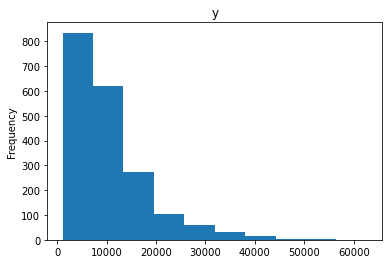

In [24]:
# y列を変数yに代入
y = data['y']
# ヒストグラムの可視化
y.plot.hist(title="y")
# 可視化結果を表示する為に必要な関数
plt.show()

また、質的データであるstageの分布を確認するために棒グラフで可視化してみましょう。<br>
stageにはJ1とJ2が存在します。<br>

In [25]:
# グラフ図の文字化けを防ぐための置換
data['stage'] = data['stage'].replace({'Ｊ１': 'J1', 'Ｊ２': 'J2'})
# データの値の頻度を計算
data['stage'].value_counts()

J2    1188
J1     764
Name: stage, dtype: int64

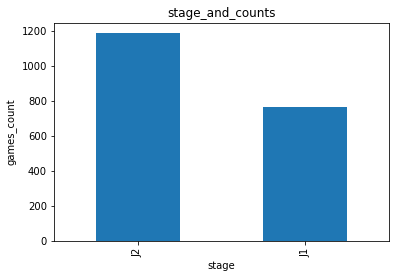

In [26]:
# 頻度値を算出
counts = data['stage'].value_counts()
# 棒グラフの可視化
counts.plot.bar(title='stage_and_counts')
#x軸とy軸に名前を付与
plt.xlabel('stage')
plt.ylabel('games_count')
# 可視化結果を表示する為に必要な関数
plt.show()

J1が764試合、J2が1188試合とJ2の試合数の方が多いことが分かりました。元々J2の方がチーム数が多いので、必然的に試合数も多くなっています。<br>

ここで「仮説１：収容人数(capa)が多いスタジアムほど観客数(y)は多いのではないか」に対してcapaとyの散布図を描いてみます。<br>
散布図の結果により、capaとyに正の相関関係(一方が増加するともう一方も増加する関係)が存在することが分かります。<br>
収容人数からある程度の観客数を予測することができそうです。<br>

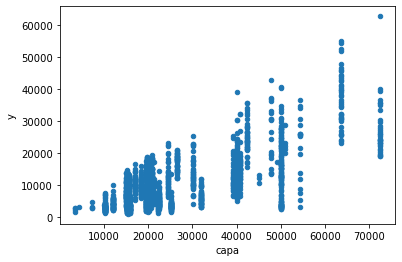

In [27]:
# capaとyの散布図
data.plot.scatter(x='capa', y='y')
plt.show()

一応各説明変数の相関係数を確認すると、capaとyとの相関係数が約0.7と高い数値になっています。<br>

In [28]:
# 相関係数を表示
data.corr()

,id,y,year,home_score,away_score,temperature,humidity,capa,month,match_num
id,1.000000,-0.176920,0.942649,-0.025286,-0.008693,0.050131,-0.123654,-0.111546,-0.097166,-0.032474
y,-0.176920,1.000000,0.003211,0.056229,0.018226,-0.028072,-0.100557,0.688290,0.105861,-0.044138
year,0.942649,0.003211,1.000000,-0.019708,0.006581,-0.040849,-0.196105,0.014548,-0.259396,-0.258279
home_score,-0.025286,0.056229,-0.019708,1.000000,-0.008761,0.016518,0.060557,0.046978,0.078402,0.066140
away_score,-0.008693,0.018226,0.006581,-0.008761,1.000000,0.012447,0.042446,-0.007139,0.007625,-0.002658
temperature,0.050131,-0.028072,-0.040849,0.016518,0.012447,1.000000,0.192701,-0.031298,0.381236,0.427351
humidity,-0.123654,-0.100557,-0.196105,0.060557,0.042446,0.192701,1.000000,-0.068175,0.295952,0.304965
capa,-0.111546,0.688290,0.014548,0.046978,-0.007139,-0.031298,-0.068175,1.000000,0.006253,-0.088082
month,-0.097166,0.105861,-0.259396,0.078402,0.007625,0.381236,0.295952,0.006253,1.000000,0.957339
match_num,-0.032474,-0.044138,-0.258279,0.066140,-0.002658,0.427351,0.304965,-0.088082,0.957339,1.000000


次に「仮説２：気温(temperature)が暑すぎたり寒すぎたり、湿度(humidity)が高すぎたりすると観客数は少ないのではないか」に対して、temperatureとyの散布図及びhumidityとyの散布図をそれぞれ描いてみます。<br>
散布図の結果により、これらの特徴量には相関関係が存在しないので、この仮説は正しくなさそうです。従って、気温と湿度は予測に使うべきではありません。<br>

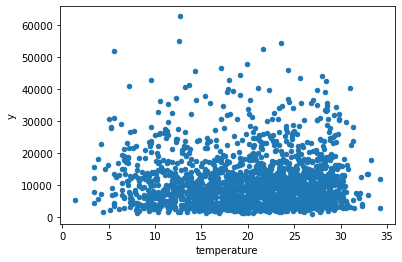

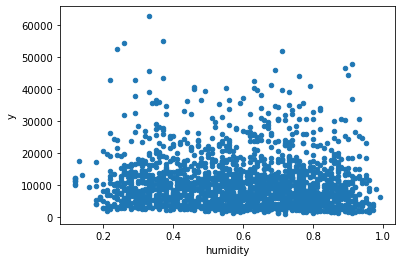

In [29]:
# temperatureとyの散布図
data.plot.scatter(x='temperature', y='y')
plt.show()
# humidityとyの散布図
data.plot.scatter(x='humidity', y='y')
plt.show()

「仮説３：平日よりも土日の方が観客数は増えるのではないか」に対してweekをx軸、yをy軸にした『箱ひげ図』を描いてみます。<br>
箱ひげ図とはデータを可視化するグラフの1つで、データの分布を「箱」と「ひげ」で表したグラフで、<br>
質的データに対して量的データがどのあたりの値に集中しているかをひと目で捉えることができます。<br>
以下の箱ひげ図の結果により、土曜は仮説通り他の曜日よりも観客数が大きくなっているのが読み取れます。しかし、日曜は平日と変わらないことが分かりました。<br>

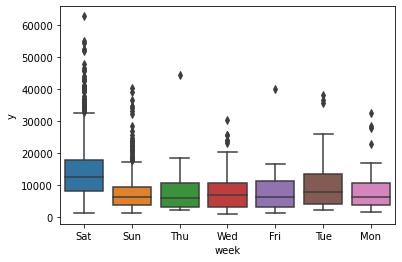

In [30]:
# 箱ひげ図の文字化けを防ぐため英字に置換
data['week'] = data['week'].replace({'日':'Sun', '月':'Mon', '火':'Tue', '水':'Wed', '木':'Thu', '金':'Fri', '土':'Sat'})
# weekをx軸、yをy軸にした箱ひげ図
sns.boxplot(data=data, x='week', y='y')
plt.show()

「仮説４：J1の方がJ2よりもレベルが高く有名なチームも多いので、観客数もJ1の方が多いのではないか」に対してstageとyの箱ひげ図を描くと、<br>
仮説通りJ1の方が観客数が多いことが分かります。<br>

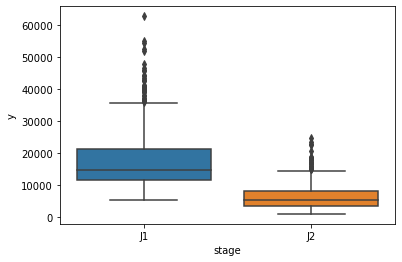

In [31]:
# stageをx軸、yをy軸にした箱ひげ図
sns.boxplot(data=data, x='stage', y='y')
plt.show()

「仮説５：8月は夏休みなので、観客数は増えるのではないか」に対してmonthとyの箱ひげ図を描くと、<br>
8月は観客数が増えるわけではない様です。一方、12月は観客数が増えることが発見できました。<br>

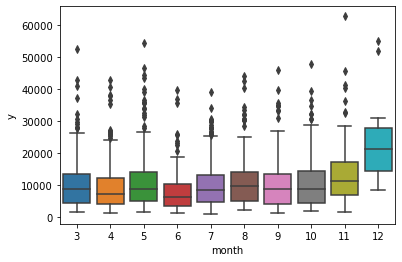

In [32]:
# monthをx軸、yをy軸にした箱ひげ図
sns.boxplot(data=data, x='month', y='y')
plt.show()

「仮説６：チームによって人気度が違うので、観客数も異なるのではないか」に対してhomeとy及びawayとyの箱ひげ図をそれぞれ描くと、<br>
仮説通りチームによって観客数にばらつきがあることが確認できます。チームも予測に使うことができそうです。<br>

['ベガルタ仙台' '名古屋グランパス' 'ガンバ大阪' 'サンフレッチェ広島' 'コンサドーレ札幌' 'サガン鳥栖' '川崎フロンターレ'
 '大宮アルディージャ' '柏レイソル' '浦和レッズ' '横浜Ｆ・マリノス' 'アルビレックス新潟' 'セレッソ大阪' '清水エスパルス'
 'ジュビロ磐田' 'ヴィッセル神戸' 'ＦＣ東京' '鹿島アントラーズ' '大分トリニータ' 'ヴァンフォーレ甲府' '湘南ベルマーレ'
 '徳島ヴォルティス']


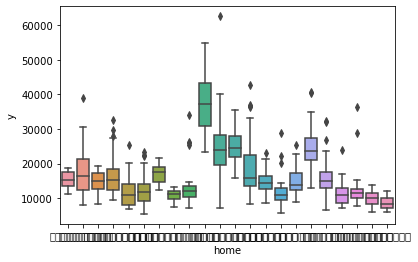

['鹿島アントラーズ' '清水エスパルス' 'ヴィッセル神戸' '浦和レッズ' 'ジュビロ磐田' 'セレッソ大阪' 'アルビレックス新潟'
 'ＦＣ東京' '横浜Ｆ・マリノス' '柏レイソル' 'ベガルタ仙台' '大宮アルディージャ' 'ガンバ大阪' 'サンフレッチェ広島'
 'サガン鳥栖' 'コンサドーレ札幌' '名古屋グランパス' '川崎フロンターレ' 'ヴァンフォーレ甲府' '湘南ベルマーレ' '大分トリニータ'
 '徳島ヴォルティス']


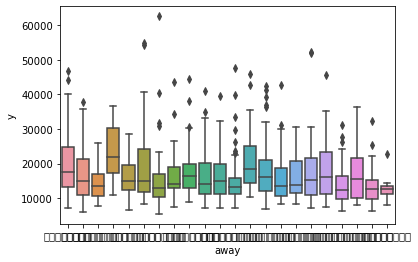

In [33]:
# stageがJ1のデータだけ抜き出しdata_J1に代入
data_J1 = data[data['stage'] == 'J1']
# data_J1のhome(ホームチーム)の要素を表示
print(data_J1['home'].unique())
# stageがJ1のデータでhomeとyの箱ひげ図
sns.boxplot(data=data_J1, x='home', y='y')
plt.show()
# data_J1のaway(アウェイチーム)の要素を表示
print(data_J1['away'].unique())
# stageがJ1のデータでawayとyの箱ひげ図
sns.boxplot(data=data_J1, x='away', y='y')
plt.show()

['水戸ホーリーホック' '東京ヴェルディ' 'ヴァンフォーレ甲府' 'ＦＣ岐阜' 'ファジアーノ岡山' 'アビスパ福岡' '大分トリニータ'
 '愛媛ＦＣ' '湘南ベルマーレ' 'ギラヴァンツ北九州' '栃木ＳＣ' 'ＦＣ町田ゼルビア' '松本山雅ＦＣ' '徳島ヴォルティス'
 'ザスパクサツ群馬' 'ロアッソ熊本' '京都サンガF.C.' 'ガイナーレ鳥取' 'モンテディオ山形' '横浜ＦＣ' 'カターレ富山'
 'ジェフユナイテッド千葉' 'ガンバ大阪' 'ヴィッセル神戸' 'コンサドーレ札幌' 'Ｖ・ファーレン長崎' 'ジュビロ磐田'
 'カマタマーレ讃岐']


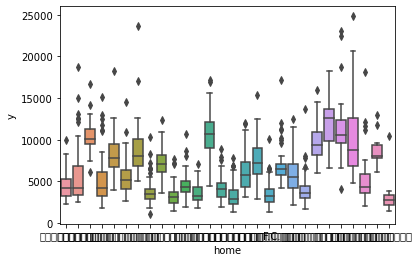

['横浜ＦＣ' '松本山雅ＦＣ' '栃木ＳＣ' 'ガイナーレ鳥取' 'カターレ富山' 'ロアッソ熊本' 'ザスパ草津' 'ＦＣ町田ゼルビア'
 '京都サンガF.C.' '徳島ヴォルティス' '大分トリニータ' 'アビスパ福岡' 'モンテディオ山形' 'ＦＣ岐阜' '湘南ベルマーレ'
 'ジェフユナイテッド千葉' 'ギラヴァンツ北九州' '水戸ホーリーホック' '愛媛ＦＣ' 'ヴァンフォーレ甲府' 'ファジアーノ岡山'
 '東京ヴェルディ' 'ヴィッセル神戸' 'ザスパクサツ群馬' 'Ｖ・ファーレン長崎' 'コンサドーレ札幌' 'ガンバ大阪' 'カマタマーレ讃岐'
 'ジュビロ磐田']


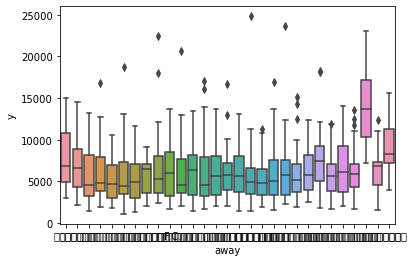

In [34]:
# stageがJ2のデータだけ抜き出しdata_J2に代入 
data_J2 = data[data['stage'] == 'J2']
# data_J2のhome(ホームチーム)の要素を表示
print(data_J2['home'].unique())
# stageがJ2のデータでhomeとyの箱ひげ図
sns.boxplot(data=data_J2, x='home', y='y')
plt.show()
# data_J2のaway(アウェイチーム)の要素を表示
print(data_J2['away'].unique())
# stageがJ2のデータでawayとyの箱ひげ図
sns.boxplot(data=data_J2, x='away', y='y')
plt.show()

### 

## ３．試合データの加工、新たな特徴量の作成

上の分析により、予測に使えそうな特徴量capa,week,stage,month,home,awayを得ました。<br>
ここからは既存のデータから新たに特徴量生成を行います。<br>
tvカラムを確認すると、／記号を用いた放送局の一覧になっており扱い辛い状態です。<br>

In [35]:
# tvカラムを確認
data['tv']

0                      スカパー／ｅ２／スカパー光／ＮＨＫ総合
1         スカパー／ｅ２／スカパー光（Ｊ　ＳＰＯＲＴＳ　４）／ＮＨＫ名古屋
2          スカパー／ｅ２／スカパー光（Ｊ　ＳＰＯＲＴＳ　１）／ＮＨＫ大阪
3                      スカパー／ｅ２／スカパー光／ＮＨＫ広島
4       スカパー／ｅ２／スカパー光（スカイ・Ａ　ｓｐｏｒｔｓ＋）／ＮＨＫ札幌
                       ...                
1948                  スカパー！／スカパー！プレミアムサービス
1949                  スカパー！／スカパー！プレミアムサービス
1950                  スカパー！／スカパー！プレミアムサービス
1951                  スカパー！／スカパー！プレミアムサービス
1952                  スカパー！／スカパー！プレミアムサービス
Name: tv, Length: 1952, dtype: object

なので'／'で各放送局を分割し、それらの個数からtv_num(放送局数)という新しい特徴量を作りましょう。<br>

In [36]:
# '／'で分割した後の要素数を返す関数
def get_num(x):
    return len(x.split('／'))

# tvカラムから放送局数を表すtv_numカラムを作成
data['tv_num'] = data['tv'].apply(get_num)
# tv_numカラムを確認
print(data['tv_num'].unique())
data

[4 3 5 2 1]


,id,y,year,stage,match,gameday,time,home,away,stadium,...,away_08,away_09,away_10,away_11,address,capa,month,week,match_num,tv_num
0,13994,18250,2012,J1,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,...,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ,宮城県仙台市泉区七北田字柳78,19694,3,Sat,1,4
1,13995,24316,2012,J1,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,...,枝村 匠馬,高木 俊幸,アレックス,大前 元紀,愛知県豊田市千石町7-2,40000,3,Sat,1,4
2,13996,17066,2012,J1,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,...,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人,大阪府吹田市千里万博公園5-2,21000,3,Sat,1,4
3,13997,29603,2012,J1,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,...,梅崎 司,柏木 陽介,原口 元気,田中 達也,広島県広島市安佐南区大塚西5-1-1,50000,3,Sat,1,4
4,13998,25353,2012,J1,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,...,山田 大記,松浦 拓弥,菅沼 実,前田 遼一,北海道札幌市豊平区羊ヶ丘1,39232,3,Sat,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948,16208,5776,2014,J2,第２２節第１日,07/20(日),18:03,水戸ホーリーホック,ザスパクサツ群馬,ケーズデンキスタジアム水戸,...,永田 亮太,青木 孝太,ダニエル ロビーニョ,宮崎 泰右,茨城県水戸市小吹町2058-1,12000,7,Sun,22,2
1949,16216,3865,2014,J2,第２２節第１日,07/20(日),19:04,愛媛ＦＣ,京都サンガF.C.,ニンジニアスタジアム,...,山瀬 功治,中山 博貴,伊藤 優汰,三平 和司,愛媛県松山市上野町乙46,15576,7,Sun,22,2
1950,16218,6420,2014,J2,第２３節第１日,07/26(土),18:03,横浜ＦＣ,ジュビロ磐田,ニッパツ三ツ沢球技場,...,松井 大輔,小林 祐希,阿部 吉朗,ポポ,神奈川県横浜市神奈川区三ツ沢西町3-1,15454,7,Sat,23,2
1951,16229,3711,2014,J2,第２４節第１日,07/30(水),19:03,水戸ホーリーホック,Ｖ・ファーレン長崎,ケーズデンキスタジアム水戸,...,野田 紘史,奥埜 博亮,スティッペ,イ ヨンジェ,茨城県水戸市小吹町2058-1,12000,7,Wed,24,2


tv_num(放送局数)とyの関係を箱ひげ図で可視化してみましょう。<br>
以下の結果から、放送局数が多いほど観客数も多いことが分かりました。<br>
放送局数が多い試合は人気の試合なので、観客数が増えている可能性があります。このtv_numは予測に使えそうです。<br>

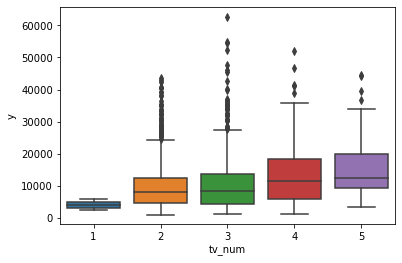

In [37]:
# tv_numをx軸、yをy軸にした箱ひげ図
sns.boxplot(data=data, x='tv_num', y='y')
plt.show()

次にweatherカラムのデータの種類と各要素数を確認すると、様々な種類の天候データが入っています。<br>
天候の種類が多すぎるので、まずは要素数が10以上の天候のみに絞り込みます。<br>

In [38]:
# weatherカラム内の天候データの種類と要素数を確認
data['weather'].value_counts()

晴           969
曇           476
雨           186
屋内           55
曇のち雨         45
晴のち曇         33
雨のち曇         31
曇のち晴         30
曇時々雨         25
晴時々曇         23
曇時々晴         18
曇一時雨         18
晴のち雨          9
晴一時雨          7
雨のち晴          4
雨時々曇          4
晴時々雨          2
晴一時曇          2
曇一時雨のち晴       1
曇一時雷雨のち曇      1
雨のち曇時々晴       1
曇時々雨のち晴       1
曇一時晴一時雨       1
晴時々雪          1
曇のち雪          1
雨時々晴          1
晴のち曇一時雨       1
雪             1
晴のち曇時々雨       1
曇一時晴          1
雪のち雨          1
曇時々晴一時雨       1
曇のち雷雨         1
Name: weather, dtype: int64

In [39]:
# 要素数が10以上の天候データのリストを作成
select_weather_bool = (data['weather'].value_counts().values > 10)
select_weather_list = data['weather'].value_counts().index[select_weather_bool].tolist()
print(select_weather_list)
# 指定のリストに該当する天候を含むデータを抽出
data = data[data['weather'].isin(select_weather_list)]
# 更新後weatherカラムの中身を確認
data['weather'].value_counts()

['晴', '曇', '雨', '屋内', '曇のち雨', '晴のち曇', '雨のち曇', '曇のち晴', '曇時々雨', '晴時々曇', '曇時々晴', '曇一時雨']


晴       969
曇       476
雨       186
屋内       55
曇のち雨     45
晴のち曇     33
雨のち曇     31
曇のち晴     30
曇時々雨     25
晴時々曇     23
曇時々晴     18
曇一時雨     18
Name: weather, dtype: int64

さらに「A時々B」「A一時B」という天候を全て「A」に置換します。「AのちB」という天候は加工せずそのまま残します。<br>

In [40]:
# 一部の天候を置換
data['weather'][data['weather'] == '曇時々雨'] = '曇'
data['weather'][data['weather'] == '晴時々曇'] = '晴'
data['weather'][data['weather'] == '曇時々晴'] = '曇'
data['weather'][data['weather'] == '曇一時雨'] = '曇'
# weatherカラムの中身を確認
data['weather'].value_counts()

晴       992
曇       537
雨       186
屋内       55
曇のち雨     45
晴のち曇     33
雨のち曇     31
曇のち晴     30
Name: weather, dtype: int64

以上の作業により、特徴量capa,week,stage,month,home,awayに加えてtv_num,weatherも作成できました。<br>
これらの中で質的変数はweek,stage,home,away,weatherであり、モデルの学習や予測に使用できる特徴量にするために『ダミー変数化』という手法による量的変数への変換が必要になります。<br>
ダミー変数化とはone-hot encodingと呼ばれる表現で質的データを量的データに変換する手法です。質的データの値の種類が多い程、ダミー変数化後のカラム数も多くなります。<br>

In [41]:
# week,stage,home,away,weatherをダミー変数化して、dummy_data_allに代入
# 後のモデル学習のため目的変数yも含む
select_columns = ['y','capa','week','stage','month','home','away','tv_num','weather']
dummy_data = pd.get_dummies(data[select_columns], drop_first=True)
# ダミー変数化後のカラム数を確認
dummy_columns = dummy_data.shape[1]
print(dummy_columns)
# ダミー変数化後のデータを確認
dummy_data = dummy_data.reset_index(drop=True)
dummy_data

101


,y,capa,month,tv_num,week_Mon,week_Sat,week_Sun,week_Thu,week_Tue,week_Wed,...,away_ＦＣ東京,away_ＦＣ町田ゼルビア,away_Ｖ・ファーレン長崎,weather_晴,weather_晴のち曇,weather_曇,weather_曇のち晴,weather_曇のち雨,weather_雨,weather_雨のち曇
0,18250,19694,3,4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,24316,40000,3,4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,25353,39232,3,4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11283,24490,3,4,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,18920,26530,3,3,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904,5776,12000,7,2,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1905,3865,15576,7,2,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1906,6420,15454,7,2,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1907,3711,12000,7,2,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0


### 

## ４．観客数予測モデルの作成

モデル作成をする前準備として、上で作成したデータを学習データと評価データに分割しましょう。<br>
モデルのゴールは、未知のデータに対してどれだけ正確に予測できるか、つまり「汎化性能」を上げることです。<br>
汎化性能を評価するためには、モデル作成に利用しない評価用のデータを残しておく必要があります。<br>

In [42]:
# 観客数を目的変数targetに代入
target = dummy_data['y']
# dummy_dataから観客数カラムを削除
dummy_data = dummy_data.drop(columns=['y'])
# dummy_dataとtargetを学習データと評価データに分割
X_train, X_valid, y_train, y_valid = train_test_split(dummy_data, target, test_size=0.25, random_state=1234)

ここから評価関数を定義します。<br>
評価関数はモデルの予測精度を定量的に測るためのものです。タスクに応じて適切な評価関数を設定する必要があります。<br>
今回は回帰問題でよく使用される『RMSE（Root Mean Squared Error：平均平方二条誤差）』を利用します。<br>
RMSEとは実測値とモデルの予測値の差を2乗し、その結果をデータの数だけ足し合わせて平均化して、最後に平方根を取った値です。<br>

$$ \operatorname{RMSE}=\sqrt{\frac{1}{N}\sum_{i=1}^N(y_i-\hat{y_i})^2} $$ <br>
<br>
$N$ : レコード数 <br>
$i=1,2,...,N$ : 各レコードのインデックス <br>
${y_i}$ : $i$番目のレコードの実測値 <br>
$\hat{y_i}$ : $i$番目のレコードの予測値 <br>

RMSEは誤差を示す尺度であるため、この評価値が小さいほど良い予測であることを示します。<br>
複数の予測対象の内1つでも大きく予測を外すと、評価値が大きく増加してしまう特徴があります。<br>

次に予測モデルを定義します。今回は『重回帰モデル』を利用してモデル作成を行っていきます。<br>
重回帰モデルとは線形回帰モデルの1つであり、入力された多くのデータを直線で表現しようとするモデルだと言えます。<br>
特に重回帰モデルは、2つ以上の説明変数から目的変数を予測するモデルを指します。以下が重回帰モデルの式となります。<br>

$$ y = {a_0} + {a_1}{X_1} + {a_2}{X_2} + {a_3}{X_3} +...+ {a_n}{X_n}  $$ <br>
<br>
${y}$ : 目的変数 <br>
$i=1,2,...,n$ : 各説明変数のインデックス <br>
${X_i}$ : 説明変数 <br>
${a_i}$ : 各説明変数の係数 <br>
${a_0}$ : 切片 <br>

In [43]:
# 重回帰モデルを定義
lr = LinearRegression()
# 学習データを用いたモデルの学習
lr.fit(X_train, y_train)

# X_trainに対して予測
y_pred_train = lr.predict(X_train)
# 学習データに対するRMSEを算出
mse_train = MSE(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
print('学習データに対するRMSE：', rmse_train)

# X_validに対して予測
y_pred_valid = lr.predict(X_valid)
# 評価データに対するRMSEを算出
mse_valid = MSE(y_valid, y_pred_valid)
rmse_valid = np.sqrt(mse_valid)
print('評価データに対するRMSE：', rmse_valid)

学習データに対するRMSE： 3122.2792841528767
評価データに対するRMSE： 3043.2065174991258


学習データのRMSEが評価データのRMSEよりも小さくないので、過学習が起きていないことが読み取れます。<br>

### 

## ５．テストデータの予測

先ほど作成＆評価したモデルを用いて、未知のデータtest.csvに対しての観客数を予測します。<br>

In [44]:
# テストデータの読み込み
test = pd.read_csv('./signate_data/sports/test.csv')
# テストデータの情報を確認
print('サンプル数:', test.shape[0], '  カラム数:', test.shape[1])
test.info()
test.head(20)

サンプル数: 313   カラム数: 10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       313 non-null    int64 
 1   year     313 non-null    int64 
 2   stage    313 non-null    object
 3   match    313 non-null    object
 4   gameday  313 non-null    object
 5   time     313 non-null    object
 6   home     313 non-null    object
 7   away     313 non-null    object
 8   stadium  313 non-null    object
 9   tv       313 non-null    object
dtypes: int64(2), object(8)
memory usage: 24.6+ KB


,id,year,stage,match,gameday,time,home,away,stadium,tv
0,15822,2014,Ｊ１,第１８節第１日,08/02(土),19:04,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,スカパー！／スカパー！プレミアムサービス
1,15823,2014,Ｊ１,第１８節第１日,08/02(土),18:34,鹿島アントラーズ,サンフレッチェ広島,県立カシマサッカースタジアム,スカパー！／スカパー！プレミアムサービス
2,15824,2014,Ｊ１,第１８節第１日,08/02(土),19:04,浦和レッズ,ヴィッセル神戸,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１／テレ玉
3,15825,2014,Ｊ１,第１８節第１日,08/02(土),19:03,柏レイソル,川崎フロンターレ,日立柏サッカー場,スカパー！／スカパー！プレミアムサービス
4,15827,2014,Ｊ１,第１８節第１日,08/02(土),19:03,アルビレックス新潟,セレッソ大阪,デンカビッグスワンスタジアム,スカパー！／スカパー！プレミアムサービス
5,15828,2014,Ｊ１,第１８節第１日,08/02(土),18:03,ガンバ大阪,横浜Ｆ・マリノス,万博記念競技場,スカパー！／スカパー！プレミアムサービス
6,15829,2014,Ｊ１,第１８節第１日,08/02(土),18:34,徳島ヴォルティス,ヴァンフォーレ甲府,鳴門・大塚スポーツパーク ポカリスエットスタジアム,スカパー！／スカパー！プレミアムサービス
7,15830,2014,Ｊ１,第１８節第１日,08/02(土),19:04,サガン鳥栖,名古屋グランパス,ベストアメニティスタジアム,スカパー！／スカパー！プレミアムサービス
8,15831,2014,Ｊ１,第１９節第１日,08/09(土),19:04,大宮アルディージャ,ガンバ大阪,ＮＡＣＫ５スタジアム大宮,スカパー！／スカパー！プレミアムサービス／テレ玉
9,15832,2014,Ｊ１,第１９節第１日,08/09(土),19:04,川崎フロンターレ,浦和レッズ,等々力陸上競技場,スカパー！／スカパー！プレミアムサービス


ただ、今のテストデータをそのまま予測モデルに入力することはできません。<br>
上の1~3で実施した、モデルに入力するための前処理を、テストデータに対しても同様に行います。<br>

In [45]:
# データフレームtestとcondition_newを、両方共「id」をキーに左外部結合
tmp_test = pd.merge(test, condition_new, on='id', how='left')
# データフレームtmp_testとstadiumを、「stadium」と「name」をキーに左外部結合
test_data = pd.merge(tmp_test, stadium, left_on='stadium', right_on='name', how='left')
test_data = test_data.drop(columns=['name'])

In [46]:
# 特徴量作成の前処理
test_data['month'] = test_data['gameday'].apply(get_month)
test_data['week'] = test_data['gameday'].apply(get_week)
test_data['match_num'] = test_data['match'].apply(get_match)
test_data['humidity'] = test_data['humidity'].apply(get_humidity)
test_data['stage'] = test_data['stage'].replace({'Ｊ１': 'J1', 'Ｊ２': 'J2'})
test_data['week'] = test_data['week'].replace({'日':'Sun', '月':'Mon', '火':'Tue', '水':'Wed', '木':'Thu', '金':'Fri', '土':'Sat'})
test_data['tv_num'] = test_data['tv'].apply(get_num)

In [47]:
# weatherの中身を確認
print(test_data['weather'].value_counts())

晴          152
曇           75
雨           33
雨のち曇        14
屋内          11
晴のち曇         9
曇時々雨         5
曇一時雨         3
曇時々晴         3
曇のち雨         3
曇のち晴         1
晴時々曇         1
晴のち雪         1
雨のち曇一時雨      1
晴一時雨         1
Name: weather, dtype: int64


In [48]:
# weatherの一部の天候を置換
test_data['weather'][test_data['weather'] == '曇時々雨'] = '曇'
test_data['weather'][test_data['weather'] == '曇一時雨'] = '曇'
test_data['weather'][test_data['weather'] == '曇時々晴'] = '曇'
test_data['weather'][test_data['weather'] == '晴一時雨'] = '晴'
test_data['weather'][test_data['weather'] == '晴時々曇'] = '晴'
test_data['weather'][test_data['weather'] == '晴のち雪'] = '晴のち曇'
test_data['weather'][test_data['weather'] == '雨のち曇一時雨'] = '雨のち曇'
# weatherカラムの中身を確認
print(test_data['weather'].value_counts())

晴       154
曇        86
雨        33
雨のち曇     15
屋内       11
晴のち曇     10
曇のち雨      3
曇のち晴      1
Name: weather, dtype: int64


In [49]:
# test_dataの情報と内容を確認
test_data.info()
test_data.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313 entries, 0 to 312
Data columns (total 46 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           313 non-null    int64  
 1   year         313 non-null    int64  
 2   stage        313 non-null    object 
 3   match        313 non-null    object 
 4   gameday      313 non-null    object 
 5   time         313 non-null    object 
 6   home         313 non-null    object 
 7   away         313 non-null    object 
 8   stadium      313 non-null    object 
 9   tv           313 non-null    object 
 10  home_score   313 non-null    int64  
 11  away_score   313 non-null    int64  
 12  weather      313 non-null    object 
 13  temperature  313 non-null    float64
 14  humidity     313 non-null    float64
 15  referee      313 non-null    object 
 16  home_team    313 non-null    object 
 17  home_01      313 non-null    object 
 18  home_02      313 non-null    object 
 19  home_03 

,id,year,stage,match,gameday,time,home,away,stadium,tv,...,away_08,away_09,away_10,away_11,address,capa,month,week,match_num,tv_num
0,15822,2014,J1,第１８節第１日,08/02(土),19:04,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,スカパー！／スカパー！プレミアムサービス,...,家長 昭博,富山 貴光,ムルジャ,ズラタン,宮城県仙台市泉区七北田字柳78,19694,8,Sat,18,2
1,15823,2014,J1,第１８節第１日,08/02(土),18:34,鹿島アントラーズ,サンフレッチェ広島,県立カシマサッカースタジアム,スカパー！／スカパー！プレミアムサービス,...,山岸 智,石原 直樹,髙萩 洋次郎,佐藤 寿人,茨城県鹿嶋市神向寺後山26-2,40728,8,Sat,18,2
2,15824,2014,J1,第１８節第１日,08/02(土),19:04,浦和レッズ,ヴィッセル神戸,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１／テレ玉,...,高橋 峻希,小川 慶治朗,森岡 亮太,マルキーニョス,埼玉県さいたま市緑区中野田500,63700,8,Sat,18,4
3,15825,2014,J1,第１８節第１日,08/02(土),19:03,柏レイソル,川崎フロンターレ,日立柏サッカー場,スカパー！／スカパー！プレミアムサービス,...,森谷 賢太郎,金久保 順,小林 悠,大久保 嘉人,千葉県柏市日立台1-2-50,15349,8,Sat,18,2
4,15827,2014,J1,第１８節第１日,08/02(土),19:03,アルビレックス新潟,セレッソ大阪,デンカビッグスワンスタジアム,スカパー！／スカパー！プレミアムサービス,...,キム ソンジュン,フォルラン,南野 拓実,杉本 健勇,新潟県新潟市中央区清五郎67-12,42300,8,Sat,18,2
5,15828,2014,J1,第１８節第１日,08/02(土),18:03,ガンバ大阪,横浜Ｆ・マリノス,万博記念競技場,スカパー！／スカパー！プレミアムサービス,...,兵藤 慎剛,中村 俊輔,齋藤 学,伊藤 翔,大阪府吹田市千里万博公園5-2,21000,8,Sat,18,2
6,15829,2014,J1,第１８節第１日,08/02(土),18:34,徳島ヴォルティス,ヴァンフォーレ甲府,鳴門・大塚スポーツパーク ポカリスエットスタジアム,スカパー！／スカパー！プレミアムサービス,...,阿部 翔平,阿部 拓馬,ジウシーニョ,クリスティアーノ,徳島県鳴門市撫養町立岩字四枚61,19637,8,Sat,18,2
7,15830,2014,J1,第１８節第１日,08/02(土),19:04,サガン鳥栖,名古屋グランパス,ベストアメニティスタジアム,スカパー！／スカパー！プレミアムサービス,...,田口 泰士,レアンドロ ドミンゲス,玉田 圭司,永井 謙佑,佐賀県鳥栖市京町812,24490,8,Sat,18,2
8,15831,2014,J1,第１９節第１日,08/09(土),19:04,大宮アルディージャ,ガンバ大阪,ＮＡＣＫ５スタジアム大宮,スカパー！／スカパー！プレミアムサービス／テレ玉,...,阿部 浩之,倉田 秋,宇佐美 貴史,パトリック,埼玉県さいたま市大宮区高鼻町4,15600,8,Sat,19,3
9,15832,2014,J1,第１９節第１日,08/09(土),19:04,川崎フロンターレ,浦和レッズ,等々力陸上競技場,スカパー！／スカパー！プレミアムサービス,...,宇賀神 友弥,柏木 陽介,梅崎 司,興梠 慎三,神奈川県川崎市中原区等々力1-1,26530,8,Sat,19,2


これでダミー変数化の準備が整いました。学習データのときと同様にダミー変数化を行います。<br>

In [50]:
# ダミー変数化してX_testに代入
select_columns_test = ['capa','week','stage','month','home','away','tv_num','weather']
X_test = pd.get_dummies(test_data[select_columns_test], drop_first=True)

ここで予測モデルの学習に使用した学習データの大きさと、これから予測モデルに入力しようとしているテストデータの大きさを比較してみましょう。<br>
テストデータのカラム数が学習データよりも小さいです。実は学習データには存在する一部の曜日やチーム名の値が、テストデータには存在していないため<br>
ダミー変数化した際に、カラム数に違いが出るという問題が起きています。<br>

In [51]:
# モデルに入力した学習データのカラム数
print('学習データのカラム数：', X_train.shape[1])
# 学習データのカラム一覧
X_train.columns

学習データのカラム数： 100


Index(['capa', 'month', 'tv_num', 'week_Mon', 'week_Sat', 'week_Sun',
       'week_Thu', 'week_Tue', 'week_Wed', 'stage_J2', 'home_アルビレックス新潟',
       'home_カターレ富山', 'home_カマタマーレ讃岐', 'home_ガイナーレ鳥取', 'home_ガンバ大阪',
       'home_ギラヴァンツ北九州', 'home_コンサドーレ札幌', 'home_サガン鳥栖', 'home_サンフレッチェ広島',
       'home_ザスパクサツ群馬', 'home_ジェフユナイテッド千葉', 'home_ジュビロ磐田', 'home_セレッソ大阪',
       'home_ファジアーノ岡山', 'home_ベガルタ仙台', 'home_モンテディオ山形', 'home_ロアッソ熊本',
       'home_ヴァンフォーレ甲府', 'home_ヴィッセル神戸', 'home_京都サンガF.C.', 'home_名古屋グランパス',
       'home_大分トリニータ', 'home_大宮アルディージャ', 'home_川崎フロンターレ', 'home_徳島ヴォルティス',
       'home_愛媛ＦＣ', 'home_東京ヴェルディ', 'home_松本山雅ＦＣ', 'home_柏レイソル', 'home_栃木ＳＣ',
       'home_横浜Ｆ・マリノス', 'home_横浜ＦＣ', 'home_水戸ホーリーホック', 'home_浦和レッズ',
       'home_清水エスパルス', 'home_湘南ベルマーレ', 'home_鹿島アントラーズ', 'home_ＦＣ岐阜',
       'home_ＦＣ東京', 'home_ＦＣ町田ゼルビア', 'home_Ｖ・ファーレン長崎', 'away_アルビレックス新潟',
       'away_カターレ富山', 'away_カマタマーレ讃岐', 'away_ガイナーレ鳥取', 'away_ガンバ大阪',
       'away_ギラヴァンツ北九州', 'away_コンサドーレ札幌', 'away_サガン鳥栖', 'awa

In [52]:
# モデルに入力するテストデータのカラム数
print('テストデータのカラム数：', X_test.shape[1])
# テストデータのカラム一覧
X_test.columns

テストデータのカラム数： 94


Index(['capa', 'month', 'tv_num', 'week_Mon', 'week_Sat', 'week_Sun',
       'week_Tue', 'week_Wed', 'stage_J2', 'home_アルビレックス新潟', 'home_カターレ富山',
       'home_カマタマーレ讃岐', 'home_ガンバ大阪', 'home_ギラヴァンツ北九州', 'home_コンサドーレ札幌',
       'home_サガン鳥栖', 'home_サンフレッチェ広島', 'home_ザスパクサツ群馬', 'home_ジェフユナイテッド千葉',
       'home_ジュビロ磐田', 'home_セレッソ大阪', 'home_ファジアーノ岡山', 'home_ベガルタ仙台',
       'home_モンテディオ山形', 'home_ロアッソ熊本', 'home_ヴァンフォーレ甲府', 'home_ヴィッセル神戸',
       'home_京都サンガF.C.', 'home_名古屋グランパス', 'home_大分トリニータ', 'home_大宮アルディージャ',
       'home_川崎フロンターレ', 'home_徳島ヴォルティス', 'home_愛媛ＦＣ', 'home_東京ヴェルディ',
       'home_松本山雅ＦＣ', 'home_柏レイソル', 'home_栃木ＳＣ', 'home_横浜Ｆ・マリノス', 'home_横浜ＦＣ',
       'home_水戸ホーリーホック', 'home_浦和レッズ', 'home_清水エスパルス', 'home_湘南ベルマーレ',
       'home_鹿島アントラーズ', 'home_ＦＣ岐阜', 'home_ＦＣ東京', 'home_Ｖ・ファーレン長崎',
       'away_アルビレックス新潟', 'away_カターレ富山', 'away_カマタマーレ讃岐', 'away_ガンバ大阪',
       'away_ギラヴァンツ北九州', 'away_コンサドーレ札幌', 'away_サガン鳥栖', 'away_サンフレッチェ広島',
       'away_ザスパクサツ群馬', 'away_ジェフユナイテッド千葉', 'away_ジュビロ

このままでは予測モデルに入力することができない（カラム数が異なるデータをモデルに入力するとエラーとなる）ので、<br>
足りないカラムを学習データと同じカラム一覧になるように追加していきます。<br>

In [53]:
# テストデータに足りないカラムを追加作成(値は全て0)
X_test.insert(X_test.columns.get_loc('week_Tue'), 'week_Thu', 0)
X_test.insert(X_test.columns.get_loc('home_ガンバ大阪'), 'home_ガイナーレ鳥取', 0)
X_test.insert(X_test.columns.get_loc('home_Ｖ・ファーレン長崎'), 'home_ＦＣ町田ゼルビア', 0)
X_test.insert(X_test.columns.get_loc('away_ガンバ大阪'), 'away_ガイナーレ鳥取', 0)
X_test.insert(X_test.columns.get_loc('away_ジェフユナイテッド千葉'), 'away_ザスパ草津', 0)
X_test.insert(X_test.columns.get_loc('away_Ｖ・ファーレン長崎'), 'away_ＦＣ町田ゼルビア', 0)
# テストデータのカラム数を確認
print('修正後テストデータのカラム数：', X_test.shape[1])

修正後テストデータのカラム数： 100


これでテストデータを予測モデルに入力し、予測を行うことができるようになりました。<br>

In [54]:
# 予測値の算出
y_pred_test = lr.predict(X_test)

In [55]:
# 予測結果をデータフレーム型でまとめ、提出用のCSVファイルを作成
submission = pd.DataFrame({'id': test_data['id'], 'y': y_pred_test})
submission.to_csv('./signate_result/sports_competition_predicted.csv', header=False, index=False)
# 予測結果を表示
submission

,id,y
0,15822,14051.528237
1,15823,18835.878745
2,15824,36309.121774
3,15825,13598.934248
4,15827,28533.381074
...,...,...
308,16432,4674.546558
309,16433,9149.171761
310,16434,5151.194000
311,16435,6821.105841


出力したCSVファイルをコンペティションにて投稿して完了です。

最終投稿日時：2021-05-23 22:50:12 <br>
最終評価：3,637.1870898 <br>
最終順位：543位 / 1,395人投稿 <br>